# Chapitre 09: SVM

Projet similaire, i.e. faire les sections "*lab*" du livre "Introduction to Statistical Learning" en Python avec des notebooks : https://github.com/JWarmenhoven/ISLR-python

## Imports

In [1]:
%load_ext watermark

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

In [212]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC, SVC

In [27]:
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['lines.markersize'] = 10

In [6]:
sns.set_style("dark")

In [7]:
%matplotlib inline

In [8]:
%watermark -d -u -v -p numpy,scipy,pandas,statsmodels,seaborn,matplotlib -w

last updated: 2020-09-20 

CPython 3.8.6rc1
IPython 7.18.1

numpy 1.19.2
scipy 1.5.2
pandas 1.1.2
statsmodels 0.12.0
seaborn 0.11.0
matplotlib 3.3.2
watermark 2.0.2


## À propos des classifieurs SVM du sklearn

* [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) : son implémentation est basée sur la bibliothèque C++ `libsvm`. Par défaut, c'est le noyau *Radial Basis Function* aka *RBF* qui est utilisé. Pour avoir des résultats équivalents à `LinearSVC`, il faut mettre `kernal="linear"`.

* [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) est similaire à SVC avec le paramètre `kernel=’linear’`, mais implémentée avec `liblinear` plutôt que `libsvm`. Contrairement à `SVC`, on n'a pas accès aux *support vectors*.

* Dans le livre ISLR, le paquet R qui est utilisé s'appelle [e1017](https://cran.r-project.org/web/packages/e1071/index.html). Ce paquet utilise la bibliothèque C++ `libsvm`.

* La documentation PDF du paquet R utilisé dans ISLR : https://cran.r-project.org/web/packages/e1071/e1071.pdf

## Quelques fonctions

C'est des fonctions inspirées de la doc de sklearn et aussi d'articles de blog

* https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html 
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92

In [238]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    xy = np.c_[xx.ravel(), yy.ravel()]
    z = clf.decision_function(xy).reshape(xx.shape)
    # droite du plan et les marges en pointillés
    ax.contour(xx, yy, z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # les support vectors quand disponibles dans le modèle (SVC)
    if hasattr(clf, "support_vectors_"):
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    # les couleurs par classe de par et d'autres du plan
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_roc(y_test, y_hat, pos_label=2):
    "Compute ROC curve and ROC area for each class"
    # false positive rate, true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat, pos_label=2)
    # Area under the ROC curve
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

## Support Vector Classifier

C'est un classifieur très similaire au **maximal margin classifier**. On autorise une marge d'erreur des points qui peuvent se situer dans "l'épaisseur" de la marge, ainsi que des points du "mauvais" côté de l'hyperplan.

* C'est le paramètre `C` dans sklearn.
* Similaire au paramètre `cost` dans R.

$$
y_i(\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \ldots + \beta_p x_{ip}) \geq M(1 - \epsilon_i)
$$

$$
\epsilon_i \geq 0, \sum_i^n \epsilon_i \leq C
$$

In [77]:
SEED = 1337
np.random.seed(SEED)

On construit deux *features* aléatoire (normale centrée réduite)

In [78]:
X = np.random.randn(20, 2)

In [57]:
# deux classes d'objets (-1, 1)
y = np.concatenate(((-1) * np.ones(10), np.ones(10))).astype(np.int)

In [58]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

Le code R originel ajoute 1.
```r
X[y==1,] == X[y==1,] + 1
```
Pour le second exemple avec les mêmes données, on ajoutera plus pour avoir des points suffisamment distincts (deux classes séparables linéairement).

In [79]:
X[y == 1] += 1

In [80]:
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y

In [81]:
df

,x1,x2,y
0,-0.703187,-0.490282,-1
1,-0.321814,-1.755079,-1
2,0.206664,-2.011265,-1
3,-0.557251,0.337217,-1
4,1.548836,-1.370737,-1
5,1.425291,-0.279464,-1
6,-0.559628,1.186383,-1
7,1.698519,-1.691220,-1
8,-0.699523,0.582963,-1
9,0.978223,-1.217372,-1


<AxesSubplot:xlabel='x1', ylabel='x2'>

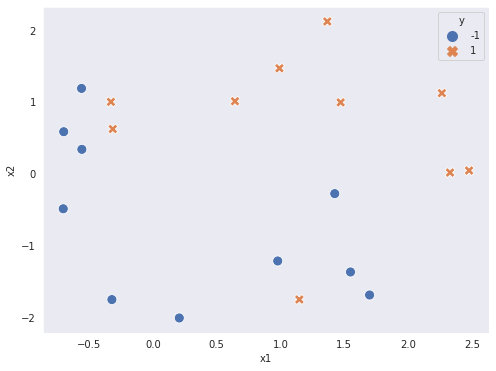

In [82]:
# Points (x1, x2), deux classes d'objet.
sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")

On voit qu'on a dû mal à avoir deux classes séparables linéairement.

In [127]:
sns.color_palette("deep", as_cmap=True)

['#4C72B0',
 '#DD8452',
 '#55A868',
 '#C44E52',
 '#8172B3',
 '#937860',
 '#DA8BC3',
 '#8C8C8C',
 '#CCB974',
 '#64B5CD']

### Comparaison LinearSVC et SVC(kernel="linear")

On reprend le premier exemple du ISLR.

Le code R utilise les lignes suivantes :

```r
library(e1071)
dat = data.frame(x=x, y=as.factor(y))
svmfit = svm(y~., data=dat, kernel="linear", cost=10, scale=FALSE)
```

In [84]:
linear_svc = LinearSVC(C=10, dual=False, random_state=12)
linear_svc.fit(X, y)

LinearSVC(C=10, dual=False, random_state=12)

In [85]:
# La grille pour permettre de colorer / distinguer les classes d'objet de par
# et d'autre de l'hyperplan.
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

In [86]:
# on récupère les codes couleurs de la palette "categorical" *deep*.
colors = sns.color_palette("deep", as_cmap=True)

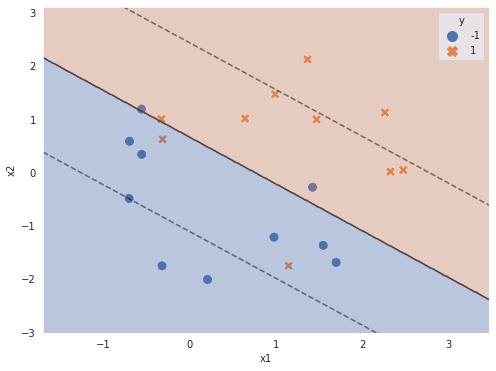

In [87]:
# on affiche de nouveau les points
# - la droite du plan
# - les marges (en pointillé)
# - les couleurs dans le plan qui vont distinguer les classes d'objet
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, linear_svc, xx, yy, colors=colors[:2], alpha=.3)

In [88]:
# La même chose avec SVC.
svc = SVC(kernel="linear", C=10, random_state=12)
svc.fit(X, y)

SVC(C=10, kernel='linear', random_state=12)

In [89]:
# Les support vectors (rappel : non dispo pour LinearSVC)
svc.support_vectors_

array([[-0.55725071,  0.33721701],
       [ 1.54883597, -1.37073656],
       [ 1.4252914 , -0.27946391],
       [-0.55962791,  1.18638337],
       [-0.69952284,  0.58296284],
       [-0.32939545,  0.99854526],
       [-0.31465268,  0.62038826],
       [ 1.14794178, -1.75372579],
       [ 0.64310368,  1.00771784]])

On peut voir les trois points, les *support vectors* du modèle.

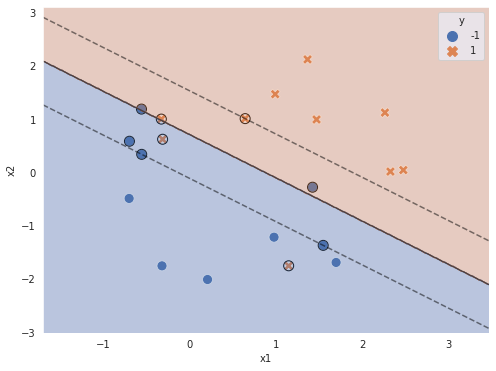

In [90]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, svc, xx, yy, colors=colors[:2], alpha=.3)

En diminuant la valeur de `C`, on obtient ce genre *support vectors*. On est ici plus "permissif" car on a des points qui se trouvent être "dans la marge". Une variance plus faible mais un biais plus élevé.

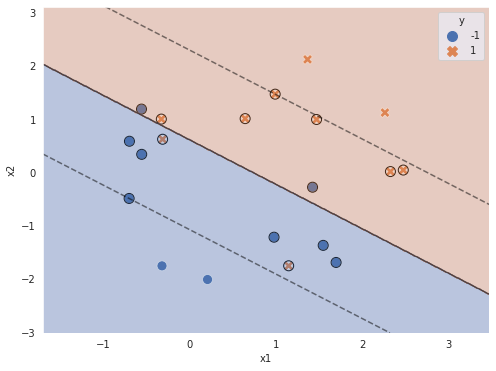

In [91]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, SVC(kernel="linear", C=0.1).fit(X, y),
              xx, yy, colors=colors[:2], alpha=.3)

### SVC / Deuxième exemple

Avec des X / y beaucoup mieux "séparables" linéairement.

```R
# exemple en R
x[y==1,] = x[y==1,] + 0.5
plot(x, col=(y+5)/2)
```

In [92]:
X[y==1] += 1

In [93]:
df2 = pd.DataFrame(X, columns=["x1", "x2"])
df2["y"] = y

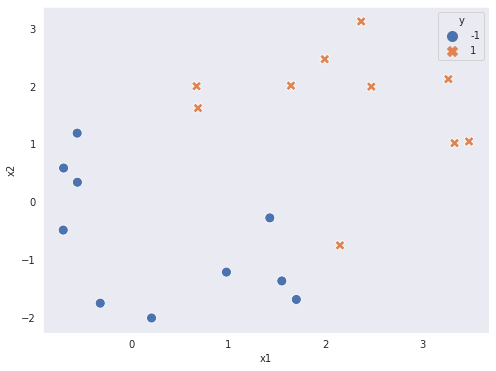

In [94]:
ax = sns.scatterplot(data=df2, x="x1", y="x2", hue="y", style="y", palette="deep")

Des données plus facilement séparables linéairement.

In [96]:
# La grille pour permettre de colorer / distinguer les classes d'objet de par
# et d'autre de l'hyperplan.
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

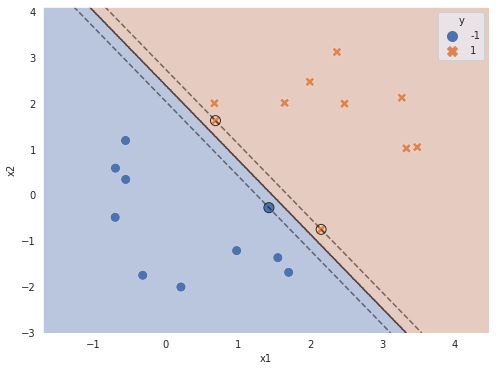

In [97]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, SVC(kernel="linear", C=10000).fit(X, y),
              xx, yy, colors=colors[:2], alpha=.3)

Une marge très fine, deux classes d'objets bien séparables.

Avec les mêmes données, on veut être plus permissif avec un coût à 1.

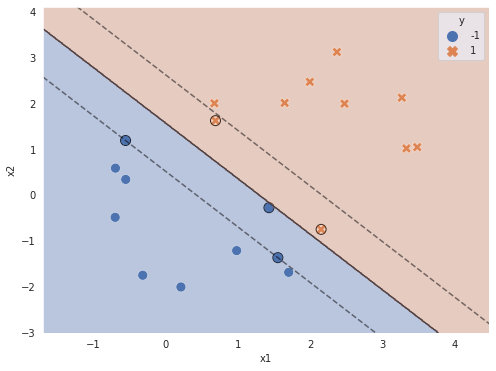

In [98]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, SVC(kernel="linear", C=1).fit(X, y),
              xx, yy, colors=colors[:2], alpha=.3)

## Support Vector Machine

On va utiliser maintenant le SVM en utilisant un noyau **non linéaire**. Utilisation de deux kernels différents:

* polynomiale
* radial

Ce dessous le code R du ISLR:

```R
# exemple en R
set.seed (1)
x = matrix(rnorm(200*2), ncol=2)
x [1:100,] = x [1:100,]+2
x [101:150,] = x [101:150,] -2
y = c (rep(1,150), rep(2,50))
dat = data.frame(x=x, y=as.factor(y))
```

In [178]:
np.random.seed(8)
X = np.random.randn(200, 2)
X[:100] += 2
X[100:150] -= 2
y = np.concatenate((np.ones(150), 2*np.ones(50)))

In [179]:
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
df

,x1,x2,y
0,2.091205,3.091283,1.0
1,0.053030,0.613650,1.0
2,-0.296492,4.409834,1.0
3,3.727836,4.204556,1.0
4,2.794828,2.976421,1.0
...,...,...,...
195,0.360994,-0.473022,2.0
196,-0.670003,0.770305,2.0
197,0.562687,-0.993338,2.0
198,-0.044764,-0.692453,2.0


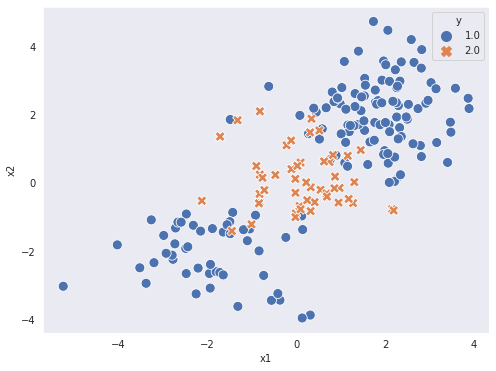

In [130]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")

On prend de manière aléatoire qu'une partie des données pour l'entraînement du modèle

In [209]:
# À noter que le dataset n'est pas équilibré. On a moins de y=2 que de y=1 (ratio 1/4 -- 3/4)
# on utilise donc un "stratify".
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=2)

In [210]:
svm = SVC(kernel="rbf", C=1, gamma=1)

In [182]:
svm.fit(X_train, y_train)

SVC(C=1, gamma=1)

In [183]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

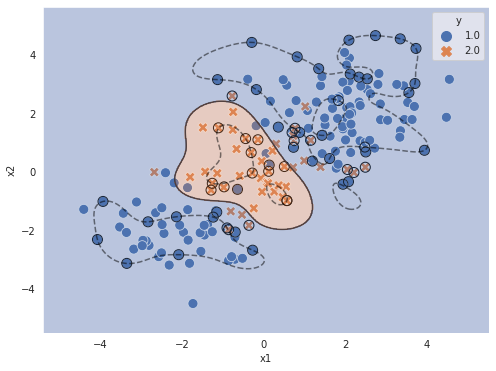

In [184]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, svm, xx, yy, colors=colors[:2], alpha=.3)

On peut être plus permissif sur les marges. On aura des frontières moins régulières avec un risque d'*overfitting*.

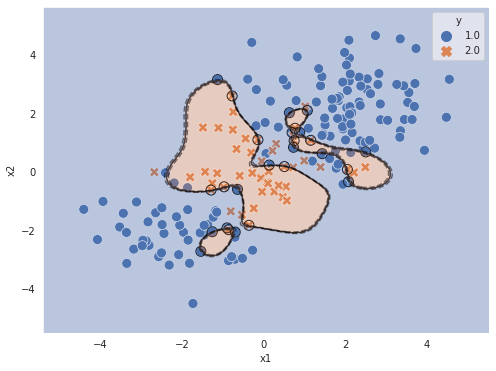

In [185]:
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="deep")
plot_contours(ax, SVC(kernel="rbf", C=1e5, gamma=1).fit(X_train, y_train),
              xx, yy, colors=colors[:2], alpha=.3)

### SVM avec du tuning de paramètres

En R, ils utilisent la fonction `tune` afin de trouver la meilleure paire de paramètres (C, gamma).

En Python, on va utiliser le `GridSearchCV` du scikit-learn.

In [186]:
# on va faire varier les paramètres C et gamma
parameters = {"C": [0.1, 1, 10, 100, 1000],
              "gamma": [0.5, 1, 2, 3, 4]}

In [193]:
svm = SVC(kernel="rbf")

In [202]:
clf = GridSearchCV(svm, parameters, cv=10, scoring='accuracy')

In [203]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [196]:
# ensemble des résultats du grid search
# clf.cv_results_

In [204]:
clf.best_estimator_

SVC(C=1, gamma=3)

In [208]:
# Le livre ISLR donne C=1, et gamma=2 (on n'a pas exactement le même tirage aléatoire des points).
clf.best_params_

{'C': 1, 'gamma': 3}

In [207]:
clf.best_score_

0.9

On va utiliser le test set et calculer la précision.

In [211]:
clf.score(X_test, y_test)

0.88

Environ 12% des points sont mal classifiés.

## Courbes ROC

On trace en Y le taux de vrai positif selon le taux de faux positif en X.

In [213]:
y_score = clf.decision_function(X_test)

In [226]:
y_test

array([1., 1., 1., 1., 1., 2., 2., 2., 2., 1., 1., 1., 2., 1., 1., 2., 1.,
       1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1.,
       2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2.,
       1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 2., 2.])

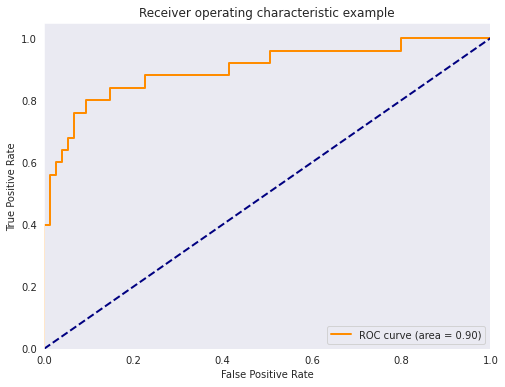

In [239]:
plot_roc(y_test, y_score)